In [29]:
import librosa
import torch
from loguru import logger

In [30]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [31]:
# 加载音频（必须单声道，采样率32kHz或16kHz）
audio_path = "./output/1729694733.wav"
(audio, _) = librosa.core.load(audio_path, sr=16000, mono=True)
# 2. 加 batch 维；panns_inference 里 stft 期望输入形状是 (batch_size, data_length)
audio = torch.from_numpy(audio).float()  # (T,)
audio = audio.unsqueeze(0)  # (1, T)

In [32]:
from panns_inference import AudioTagging, SoundEventDetection

In [33]:
# 3. 初始化模型（用内置 checkpoint，避免权重 shape 不匹配）
at = AudioTagging(
    # model=model_16k,
    checkpoint_path="./models/Cnn14_mAP=0.431.pth",
    # checkpoint_path=None,
    device=device,
)

Checkpoint path: ./models/Cnn14_mAP=0.431.pth
Using CPU.


In [34]:
# 4. 推理（传的是带 batch 维的 tensor）
clipwise_output, embedding = at.inference(audio)
# 5. 去掉多余维度，方便后面使用
clipwise_output = torch.as_tensor(clipwise_output).squeeze()  # (num_classes,)
embedding = torch.as_tensor(embedding).squeeze()  # (feature_dim,)
logger.info("clipwise_output shape: {}", clipwise_output.shape)
logger.info("embedding shape: {}", embedding.shape)

2025-12-24 14:51:16.641 | INFO     | __main__:<module>:6 - clipwise_output shape: torch.Size([527])
2025-12-24 14:51:16.642 | INFO     | __main__:<module>:7 - embedding shape: torch.Size([2048])


In [35]:
# 示例：取 top-10 标签
top_k = 10
topk_prob, topk_idx = torch.topk(clipwise_output, k=top_k)

In [36]:
logger.info("{}, {}", topk_prob, topk_idx)

logger.info("=" * 60)
logger.info("音频文件: {}", audio_path)
logger.info("检测到的前{}个标签:", top_k)
logger.info("-" * 60)

for prob, idx in zip(topk_prob.tolist(), topk_idx.tolist()):
    label = at.labels[idx]
    logger.info(f"{label}: {prob:.3f}")

logger.info("=" * 60)

2025-12-24 14:51:16.673 | INFO     | __main__:<module>:1 - tensor([0.7282, 0.7149, 0.2551, 0.0900, 0.0669, 0.0663, 0.0565, 0.0380, 0.0300,
        0.0248]), tensor([  0, 137, 498,   3, 239, 519, 252, 277, 506, 242])
2025-12-24 14:51:16.674 | INFO     | __main__:<module>:3 - ============================================================
2025-12-24 14:51:16.674 | INFO     | __main__:<module>:4 - 音频文件: ./output/1729694733.wav
2025-12-24 14:51:16.675 | INFO     | __main__:<module>:5 - 检测到的前10个标签:
2025-12-24 14:51:16.675 | INFO     | __main__:<module>:6 - ------------------------------------------------------------
2025-12-24 14:51:16.677 | INFO     | __main__:<module>:10 - Speech: 0.728
2025-12-24 14:51:16.678 | INFO     | __main__:<module>:10 - Music: 0.715
2025-12-24 14:51:16.678 | INFO     | __main__:<module>:10 - Boing: 0.255
2025-12-24 14:51:16.679 | INFO     | __main__:<module>:10 - Child speech, kid speaking: 0.090
2025-12-24 14:51:16.679 | INFO     | __main__:<module>:10 - Electronic

In [37]:
# 声音事件检测（定位具体事件的时间位置）
sed = SoundEventDetection(
    # model=model_16k_sed,
    checkpoint_path="./models/Cnn14_DecisionLevelMax_mAP=0.385.pth",
    device=device,
)

Checkpoint path: ./models/Cnn14_DecisionLevelMax_mAP=0.385.pth
Using CPU.


In [38]:
# 执行声音事件检测推理
# framewise_output: (batch_size, time_steps, classes_num)
framewise_output = sed.inference(audio)

In [39]:
# 去掉batch维度
framewise_output = torch.as_tensor(framewise_output).squeeze(0)  # (time_steps, classes_num)
logger.info("framewise_output shape: {}", framewise_output.shape)

2025-12-24 14:51:18.229 | INFO     | __main__:<module>:3 - framewise_output shape: torch.Size([1820, 527])


In [40]:
# 获取音频时长信息
audio_duration = len(audio[0]) / 16000  # 采样率16kHz
time_steps = framewise_output.shape[0]
time_resolution = audio_duration / time_steps  # 每个时间步对应的秒数

logger.info("音频时长: {:.2f}秒", audio_duration)
logger.info("时间步数: {}", time_steps)
logger.info("时间分辨率: {:.3f}秒/步", time_resolution)

2025-12-24 14:51:18.242 | INFO     | __main__:<module>:6 - 音频时长: 36.39秒
2025-12-24 14:51:18.243 | INFO     | __main__:<module>:7 - 时间步数: 1820
2025-12-24 14:51:18.243 | INFO     | __main__:<module>:8 - 时间分辨率: 0.020秒/步


In [41]:
# 找出在时间轴上出现的主要事件
# 对每个时间步，找出概率最高的事件
max_probs, max_indices = torch.max(framewise_output, dim=1)  # (time_steps,)

In [42]:
# 设置阈值，过滤低概率事件
threshold = 0.3
significant_events = []

for t in range(time_steps):
    prob = max_probs[t].item()
    if prob > threshold:
        idx = int(max_indices[t].item())
        label = sed.labels[idx]
        time_start = t * time_resolution
        time_end = (t + 1) * time_resolution
        significant_events.append({"time_start": time_start, "time_end": time_end, "label": label, "probability": prob})

# 合并连续的相同事件
merged_events = []
if significant_events:
    current_event = significant_events[0].copy()

    for event in significant_events[1:]:
        # 如果是相同标签且时间连续，则合并
        if (
                event["label"] == current_event["label"]
                and abs(event["time_start"] - current_event["time_end"]) < time_resolution * 1.5
        ):
            current_event["time_end"] = event["time_end"]
            # 更新概率为平均值
            current_event["probability"] = max(current_event["probability"], event["probability"])
        else:
            # 保存当前事件，开始新事件
            merged_events.append(current_event)
            current_event = event.copy()

    # 添加最后一个事件
    merged_events.append(current_event)

In [43]:
# 输出检测到的事件
logger.info("=" * 60)
logger.info("检测到 {} 个声音事件（阈值: {:.2f}）:", len(merged_events), threshold)
logger.info("-" * 60)

for i, event in enumerate(merged_events, 1):
    duration = event["time_end"] - event["time_start"]
    logger.info(
        f"{i}. [{event['time_start']:.2f}s - {event['time_end']:.2f}s] "
        f"({duration:.2f}s) {event['label']}: {event['probability']:.3f}"
    )

logger.info("=" * 60)

2025-12-24 14:51:18.328 | INFO     | __main__:<module>:2 - ============================================================
2025-12-24 14:51:18.328 | INFO     | __main__:<module>:3 - 检测到 3 个声音事件（阈值: 0.30）:
2025-12-24 14:51:18.329 | INFO     | __main__:<module>:4 - ------------------------------------------------------------
2025-12-24 14:51:18.329 | INFO     | __main__:<module>:8 - 1. [13.44s - 14.71s] (1.28s) Music: 0.392
2025-12-24 14:51:18.329 | INFO     | __main__:<module>:8 - 2. [19.19s - 21.11s] (1.92s) Speech: 0.389
2025-12-24 14:51:18.330 | INFO     | __main__:<module>:8 - 3. [29.43s - 36.39s] (6.96s) Speech: 0.528
2025-12-24 14:51:18.330 | INFO     | __main__:<module>:13 - ============================================================


In [44]:
# 可视化前10个最常见的事件类别随时间的变化
top_k_classes = 10
# 获取整体概率最高的类别
mean_probs = framewise_output.mean(dim=0)  # (classes_num,)
topk_mean_prob, topk_class_idx = torch.topk(mean_probs, k=top_k_classes)

logger.info("\n整体出现概率最高的{}个类别:", top_k_classes)
for prob, idx in zip(topk_mean_prob.tolist(), topk_class_idx.tolist()):
    label = sed.labels[idx]
    logger.info(f"  {label}: {prob:.3f}")

2025-12-24 14:51:18.457 | INFO     | __main__:<module>:7 - 
整体出现概率最高的10个类别:
2025-12-24 14:51:18.458 | INFO     | __main__:<module>:10 -   Speech: 0.227
2025-12-24 14:51:18.459 | INFO     | __main__:<module>:10 -   Music: 0.117
2025-12-24 14:51:18.459 | INFO     | __main__:<module>:10 -   Child speech, kid speaking: 0.008
2025-12-24 14:51:18.459 | INFO     | __main__:<module>:10 -   Inside, small room: 0.005
2025-12-24 14:51:18.461 | INFO     | __main__:<module>:10 -   Electronic music: 0.005
2025-12-24 14:51:18.461 | INFO     | __main__:<module>:10 -   Scratching (performance technique): 0.005
2025-12-24 14:51:18.462 | INFO     | __main__:<module>:10 -   Synthesizer: 0.004
2025-12-24 14:51:18.462 | INFO     | __main__:<module>:10 -   Giggle: 0.004
2025-12-24 14:51:18.462 | INFO     | __main__:<module>:10 -   Sampler: 0.004
2025-12-24 14:51:18.463 | INFO     | __main__:<module>:10 -   Cacophony: 0.004


In [45]:
import numpy as np
from matplotlib import pyplot as plt

In [46]:
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

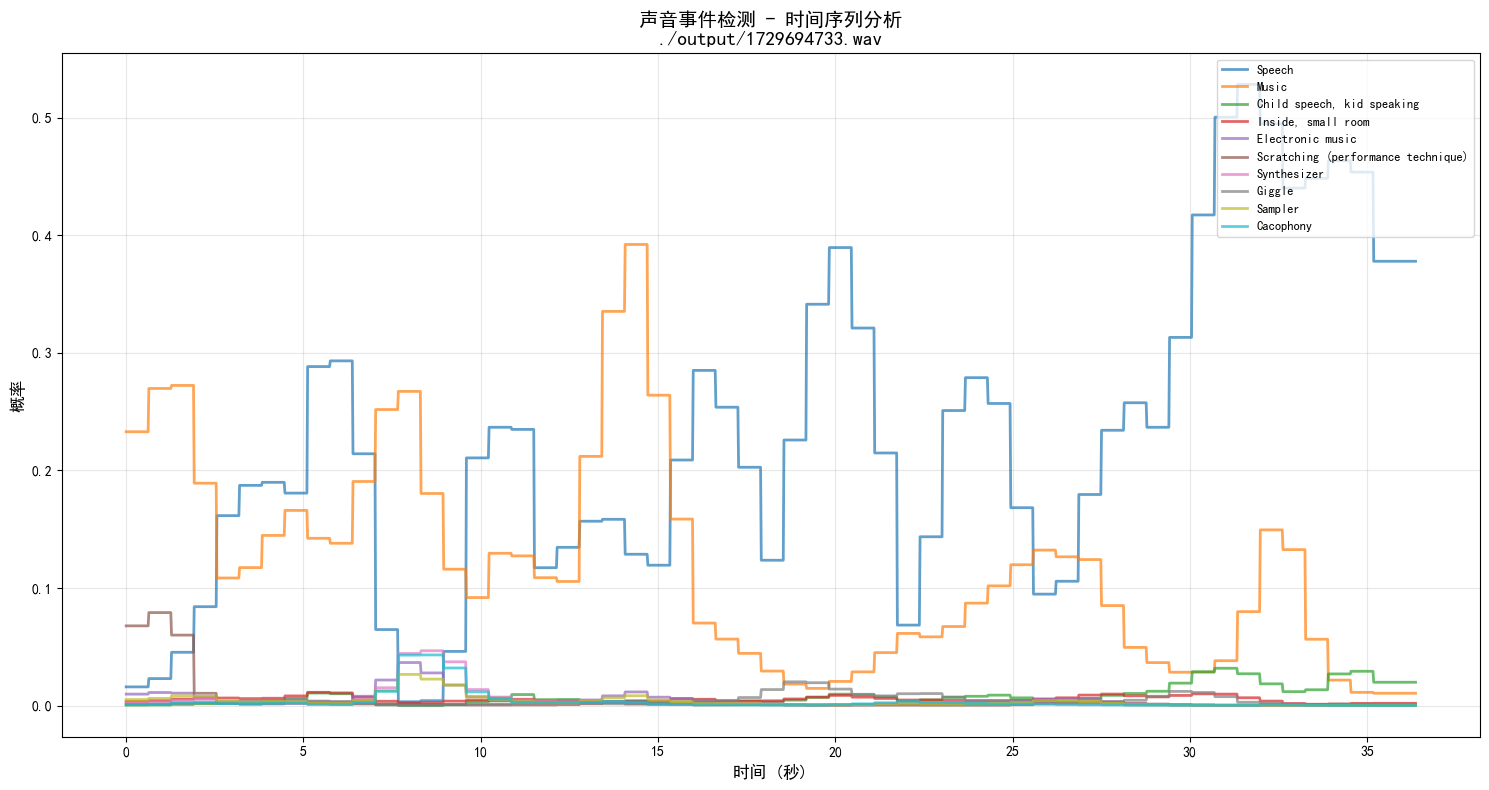

In [47]:
# 绘制时间-类别概率图
plt.figure(figsize=(15, 8))

# 创建时间轴（秒）
time_axis = np.arange(time_steps) * time_resolution

# 绘制每个类别的概率曲线
for i, class_idx in enumerate(topk_class_idx.tolist()):
    label = sed.labels[class_idx]
    probs = framewise_output[:, int(class_idx)].numpy()
    plt.plot(time_axis, probs, label=label, linewidth=2, alpha=0.7)

plt.xlabel("时间 (秒)", fontsize=12)
plt.ylabel("概率", fontsize=12)
plt.title(f"声音事件检测 - 时间序列分析\n{audio_path}", fontsize=14)
plt.legend(loc="upper right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [48]:
# 保存图表
output_plot_path = audio_path.replace(".wav", "_sed_timeline.png")
plt.savefig(output_plot_path, dpi=150, bbox_inches="tight")
logger.info("时间序列图已保存至: {}", output_plot_path)

# 显示图表
plt.show()

2025-12-24 14:51:19.072 | INFO     | __main__:<module>:4 - 时间序列图已保存至: ./output/1729694733_sed_timeline.png


<Figure size 640x480 with 0 Axes>

In [49]:
# 保存事件检测结果到文件
output_txt_path = audio_path.replace(".wav", "_sed_events.txt")
with open(output_txt_path, "w", encoding="utf-8") as f:
    f.write(f"音频文件: {audio_path}\n")
    f.write(f"音频时长: {audio_duration:.2f}秒\n")
    f.write(f"检测阈值: {threshold:.2f}\n")
    f.write(f"检测到 {len(merged_events)} 个声音事件\n")
    f.write("=" * 80 + "\n\n")

    for i, event in enumerate(merged_events, 1):
        duration = event["time_end"] - event["time_start"]
        f.write(
            f"{i}. [{event['time_start']:.2f}s - {event['time_end']:.2f}s] "
            f"({duration:.2f}s) {event['label']}: {event['probability']:.3f}\n"
        )

logger.info("事件列表已保存至: {}", output_txt_path)

2025-12-24 14:51:19.097 | INFO     | __main__:<module>:17 - 事件列表已保存至: ./output/1729694733_sed_events.txt
